### DenseNets

### 構造

$\boldsymbol{x}_0$が畳み込みネットワークを通過することを考える。  
ネットワークは$L$層含む場合、第$l$層での非線形変換(Batch Normalization,ReLU,Pooling,Convolutionなどを組み合わせたもの)を$H_l(・)$、
第$l$層の出力を$\boldsymbol{x}_l$と表す。

#### Dense connectivity(dense block)

第$l$層でその前のすべての出力$\boldsymbol{x}_0,\cdots,\boldsymbol{x}_{l-1}$を受け取る。
$$
\boldsymbol{x}_l=H_l([\boldsymbol{x}_0,\cdots,\boldsymbol{x}_{l-1}])
$$
ここで、$[\boldsymbol{x}_0,\cdots,\boldsymbol{x}_{l-1}]$は第0~$l-1$層での出力を結合したものである。

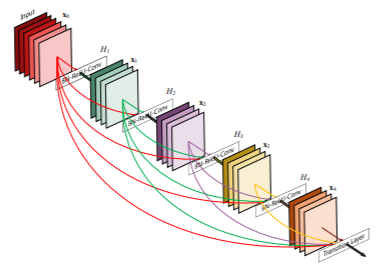

#### composite function
Batch Normalization(BN)、ReLU、3×3畳み込み(Conv)を組み合わせて使用する。  

#### Pooilng layers(transition layer)
特徴マップのダウンサンプリングを行うため、  
dense blockの間に、畳み込みとプーリングを行うtransition layerを挿入します。  
この層はBN、1×1Conv、2×2Pooligで構成されます。  
入力のチャンネル数が$m$のとき、transition layerでの出力を$m\theta$とします。  
ここで、$0<\theta\leq1$とし、$0<\theta<1$のときDenseNet-Cと呼びここでは$\theta=0.5$とします。

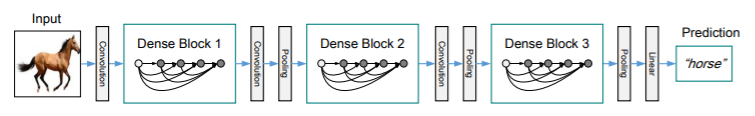

#### Growth rate
$H_l$が$k$個の特徴マップを作り出す場合、第$l$層への入力は$k_0+k(l-1)$チャンネルとなります。ここで、$k_0$は入力層のチャンネル数である。  
この$k$をgrowth rateと呼ぶ。  

#### bottleneck layers
dense blockは$k$チャンネルの特徴マップを出力するが、これは入力と比べて少ない。  
dense blockの3×3Convの前に1×1Convを追加して(bottleneck)、3×3Convへの入力チャンネル数を減らして計算効率を改善する。  
bottleneck layersの構造は、BN-ReLU-1×1Conv-BN-ReLU-3×3Convとなり、DenseNet-Bと表します。  
今回は1×1Convで$4×k$個の特徴マップを作ることとする。  
  
#### Implementation Details
最初のdense blockに入力する前に、入力を16チャンネル(ConvNet-BCの場合は、growth rateの2倍)に変換します。  
今回は、strideが2の7×7Convと3×3のmax poolingを使用します。  
最後のdense blockの後にはGlobal Avarage Poolng、そしてsoftmaxを使用して出力を出します。

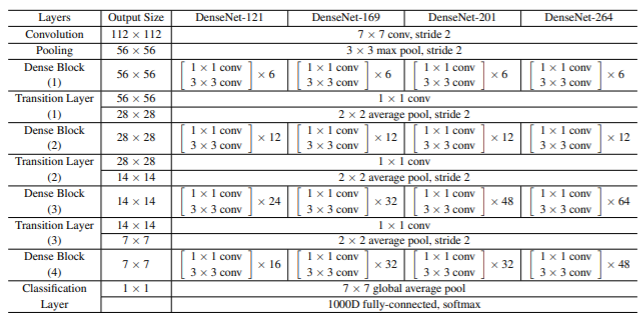

#### 学習
SGDで学習し、学習率は0.1とする。エポックが全体のエポック数の50%、75%となったら0.1を掛けて減衰させる。  
weight decayは0.0001とし、Nesterov momentumを0.9とする。  

rateを0.2としたdropout層を各畳み込み層の後に入れる。

#### 実装
$k=32$とし、DenseNet-169を実装します。使用する構造はbottleneck構造を持ったDenseNet-BCです。

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Add
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import cv2

In [2]:
class bn_relu_conv(Model):
    def __init__(self, out_channels, kernel_size=1, strides=1, name=None):
        super(bn_relu_conv, self).__init__(name=name)        
        
        self.bn = BatchNormalization()
        self.relu = Activation("relu")
        self.conv = Conv2D(out_channels, kernel_size=kernel_size, strides=strides, padding='same')
    
    def call(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        return x

In [3]:
class dense_layer(Model):
    """dense block"""
    def __init__(self, growth_rate, n):
        super(dense_layer, self).__init__(name='layer'+'_'+str(n))        
        
        self.conv1 = bn_relu_conv(out_channels=growth_rate*4, kernel_size=1, strides=1, name='layer'+'_'+str(n)+'conv1')
        self.conv2 = bn_relu_conv(out_channels=growth_rate, kernel_size=3, strides=1, name='layer'+'_'+str(n)+'conv2')

    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return out

In [4]:
class dense_block(Model):
    """dense block"""
    def __init__(self, num_layers, growth_rate, name):
        super(dense_block, self).__init__(name=name)
        
        self.dense_layers = []
        for i in range(num_layers):
            self.dense_layers += [dense_layer(growth_rate=growth_rate, n=i)]
    
    def call(self, x):
        for layer in self.dense_layers:
            main = x
            x = layer(x)
            x = concatenate([main, x])
        return x

In [5]:
class transition_layer(Model):
    def __init__(self, input_channels, name):
        super(transition_layer, self).__init__(name=name)
        self.conv = bn_relu_conv(out_channels=input_channels, kernel_size=1, strides=1, name=name+'conv1')
        self.pool = AveragePooling2D((2, 2))
    
    def call(self, x):
        out = self.conv(x)
        out = self.pool(out)
        return out

In [6]:
class dense_net(Model):
    """dense block"""
    def __init__(self, num_layers, growth_rate, num_classes=1000):
        super(dense_net, self).__init__()
        
        self.layer_dense = []
        
        in_channels=  2 * growth_rate
        
        self.layer_dense += [bn_relu_conv(out_channels=in_channels, kernel_size=7, strides=2, name='conv1'),
                             MaxPooling2D((3,3), strides=2, padding='same')]
        
        for i in range(len(num_layers)):
            self.layer_dense += [dense_block(num_layers=num_layers[i], growth_rate=growth_rate, name='block_'+str(i))]
            
            in_channels += growth_rate * num_layers[i]
            
            if i != (len(num_layers)-1):
                self.layer_dense += [transition_layer(in_channels//2, name='trans_'+str(i))]
                in_channels = in_channels//2
            
        self.layer_dense += [GlobalAveragePooling2D(),
                             Dense(num_classes, activation="softmax")]
        
    def call(self, x):
        for layer in self.layer_dense:
            x = layer(x)
        return x

In [7]:
model = dense_net(num_layers=[6,12,32,32], growth_rate=32)
model.build((None, 224, 224, 3))  # build with input shape.
dummy_input = Input(shape=(224, 224, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input), name="pretrained")
model_summary.summary()

Model: "pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (bn_relu_conv)         (None, 112, 112, 64)      9484      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
block_0 (dense_block)        (None, 56, 56, 256)       339264    
_________________________________________________________________
trans_0 (transition_layer)   (None, 28, 28, 128)       33920     
_________________________________________________________________
block_1 (dense_block)        (None, 28, 28, 512)       931968    
_________________________________________________________________
trans_1 (transition_layer)   (None, 14, 14, 256)       1

In [ ]:
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    x = 0.1
    if epoch >= 20:
        x = 0.1*0.1
    if epoch >= 30:
        x = 0.1*(0.1**2)
    return x


lr_decay = LearningRateScheduler(
    lr_schedul,
    verbose=1,
)

sgd = SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)
model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [ ]:
batch_size = 64
epochs = 40

history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[lr_decay])

In [33]:
from keras.applications.densenet import DenseNet169

base_model = DenseNet169(weights='imagenet', include_top=False, classes=1000)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    x = 0.1
    if epoch >= 20:
        x = 0.1*0.1
    if epoch >= 30:
        x = 0.1*(0.1**2)
    return x

lr_decay = LearningRateScheduler(
    lr_schedul,
    verbose=1,
)

sgd = SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)
model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[lr_decay])

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [9]:
class bn_relu_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,padding=1):
        super(bn_relu_conv, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        out = self.bn(x)
        out = self.relu(out)
        out = self.conv(out)
        out = self.drop(out)
        return out

In [10]:
class dense_layer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(dense_layer, self).__init__()        
        
        self.conv1 = bn_relu_conv(in_channels, out_channels=growth_rate*4, kernel_size=1, stride=1, padding=0)
        self.conv2 = bn_relu_conv(growth_rate*4, out_channels=growth_rate, kernel_size=3, stride=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return out

In [11]:
class dense_block(nn.Module):
    """dense block"""
    def __init__(self, in_channels, num_layers, growth_rate):
        super(dense_block, self).__init__()
        
        dense_layers = []
        for i in range(num_layers):
            dense_layers += [dense_layer(in_channels=int(in_channels + i*growth_rate), growth_rate=growth_rate)]
        self.dense_layers = nn.Sequential(*dense_layers)
        
    def forward(self, x):
        for layer in self.dense_layers:
            out = layer(x)
            x = torch.cat([x, out], 1)
        return x

In [12]:
class transition_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(transition_layer, self).__init__()
        self.conv = bn_relu_conv(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1,padding=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.pool(out)
        return out

In [13]:
class dense_net(nn.Module):
    """dense block"""
    def __init__(self, num_layers, growth_rate, num_classes=1000):
        super(dense_net, self).__init__()
        
        in_channels=  2 * growth_rate
        self.first_layer = nn.Sequential(*[bn_relu_conv(in_channels=3, out_channels=in_channels, kernel_size=7, stride=2, padding=3),
                                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)])
        layer_dense = []
        for i in range(len(num_layers)):
            layer_dense += [dense_block(in_channels=in_channels, num_layers=num_layers[i], growth_rate=growth_rate)]
            
            in_channels += growth_rate * num_layers[i]
            if i != (len(num_layers)-1):
                layer_dense += [transition_layer(in_channels=in_channels, out_channels=in_channels//2)]
                in_channels = in_channels//2
            
        layer_dense += [nn.AdaptiveAvgPool2d((1,1))]
        self.layer_dense = nn.Sequential(*layer_dense)
        self.classifier = nn.Linear(in_channels, num_classes)
        
    def forward(self, x):
        out = self.first_layer(x)
        out = self.layer_dense(out)
        out = out.view(out.shape[0], -1)
        out = self.classifier(out)
        return x

In [14]:
summary(dense_net(num_layers=[6,12,32,32], growth_rate=32), (3,224,224))

C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 224, 224]               6
              ReLU-2          [-1, 3, 224, 224]               0
            Conv2d-3         [-1, 64, 112, 112]           9,472
           Dropout-4         [-1, 64, 112, 112]               0
      bn_relu_conv-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]           8,320
          Dropout-10          [-1, 128, 56, 56]               0
     bn_relu_conv-11          [-1, 128, 56, 56]               0
      BatchNorm2d-12          [-1, 128, 56, 56]             256
             ReLU-13          [-1, 128, 56, 56]               0
           Conv2d-14           [-1, 32,

     BatchNorm2d-125          [-1, 256, 28, 28]             512
            ReLU-126          [-1, 256, 28, 28]               0
          Conv2d-127          [-1, 128, 28, 28]          32,896
         Dropout-128          [-1, 128, 28, 28]               0
    bn_relu_conv-129          [-1, 128, 28, 28]               0
     BatchNorm2d-130          [-1, 128, 28, 28]             256
            ReLU-131          [-1, 128, 28, 28]               0
          Conv2d-132           [-1, 32, 28, 28]          36,896
         Dropout-133           [-1, 32, 28, 28]               0
    bn_relu_conv-134           [-1, 32, 28, 28]               0
     dense_layer-135           [-1, 32, 28, 28]               0
     BatchNorm2d-136          [-1, 288, 28, 28]             576
            ReLU-137          [-1, 288, 28, 28]               0
          Conv2d-138          [-1, 128, 28, 28]          36,992
         Dropout-139          [-1, 128, 28, 28]               0
    bn_relu_conv-140          [-1, 128, 

     dense_layer-253           [-1, 32, 14, 14]               0
     BatchNorm2d-254          [-1, 352, 14, 14]             704
            ReLU-255          [-1, 352, 14, 14]               0
          Conv2d-256          [-1, 128, 14, 14]          45,184
         Dropout-257          [-1, 128, 14, 14]               0
    bn_relu_conv-258          [-1, 128, 14, 14]               0
     BatchNorm2d-259          [-1, 128, 14, 14]             256
            ReLU-260          [-1, 128, 14, 14]               0
          Conv2d-261           [-1, 32, 14, 14]          36,896
         Dropout-262           [-1, 32, 14, 14]               0
    bn_relu_conv-263           [-1, 32, 14, 14]               0
     dense_layer-264           [-1, 32, 14, 14]               0
     BatchNorm2d-265          [-1, 384, 14, 14]             768
            ReLU-266          [-1, 384, 14, 14]               0
          Conv2d-267          [-1, 128, 14, 14]          49,280
         Dropout-268          [-1, 128, 

            ReLU-381          [-1, 128, 14, 14]               0
          Conv2d-382           [-1, 32, 14, 14]          36,896
         Dropout-383           [-1, 32, 14, 14]               0
    bn_relu_conv-384           [-1, 32, 14, 14]               0
     dense_layer-385           [-1, 32, 14, 14]               0
     BatchNorm2d-386          [-1, 736, 14, 14]           1,472
            ReLU-387          [-1, 736, 14, 14]               0
          Conv2d-388          [-1, 128, 14, 14]          94,336
         Dropout-389          [-1, 128, 14, 14]               0
    bn_relu_conv-390          [-1, 128, 14, 14]               0
     BatchNorm2d-391          [-1, 128, 14, 14]             256
            ReLU-392          [-1, 128, 14, 14]               0
          Conv2d-393           [-1, 32, 14, 14]          36,896
         Dropout-394           [-1, 32, 14, 14]               0
    bn_relu_conv-395           [-1, 32, 14, 14]               0
     dense_layer-396           [-1, 32, 

          Conv2d-509          [-1, 128, 14, 14]         139,392
         Dropout-510          [-1, 128, 14, 14]               0
    bn_relu_conv-511          [-1, 128, 14, 14]               0
     BatchNorm2d-512          [-1, 128, 14, 14]             256
            ReLU-513          [-1, 128, 14, 14]               0
          Conv2d-514           [-1, 32, 14, 14]          36,896
         Dropout-515           [-1, 32, 14, 14]               0
    bn_relu_conv-516           [-1, 32, 14, 14]               0
     dense_layer-517           [-1, 32, 14, 14]               0
     BatchNorm2d-518         [-1, 1120, 14, 14]           2,240
            ReLU-519         [-1, 1120, 14, 14]               0
          Conv2d-520          [-1, 128, 14, 14]         143,488
         Dropout-521          [-1, 128, 14, 14]               0
    bn_relu_conv-522          [-1, 128, 14, 14]               0
     BatchNorm2d-523          [-1, 128, 14, 14]             256
            ReLU-524          [-1, 128, 

            ReLU-637            [-1, 800, 7, 7]               0
          Conv2d-638            [-1, 128, 7, 7]         102,528
         Dropout-639            [-1, 128, 7, 7]               0
    bn_relu_conv-640            [-1, 128, 7, 7]               0
     BatchNorm2d-641            [-1, 128, 7, 7]             256
            ReLU-642            [-1, 128, 7, 7]               0
          Conv2d-643             [-1, 32, 7, 7]          36,896
         Dropout-644             [-1, 32, 7, 7]               0
    bn_relu_conv-645             [-1, 32, 7, 7]               0
     dense_layer-646             [-1, 32, 7, 7]               0
     BatchNorm2d-647            [-1, 832, 7, 7]           1,664
            ReLU-648            [-1, 832, 7, 7]               0
          Conv2d-649            [-1, 128, 7, 7]         106,624
         Dropout-650            [-1, 128, 7, 7]               0
    bn_relu_conv-651            [-1, 128, 7, 7]               0
     BatchNorm2d-652            [-1, 128

         Dropout-765             [-1, 32, 7, 7]               0
    bn_relu_conv-766             [-1, 32, 7, 7]               0
     dense_layer-767             [-1, 32, 7, 7]               0
     BatchNorm2d-768           [-1, 1184, 7, 7]           2,368
            ReLU-769           [-1, 1184, 7, 7]               0
          Conv2d-770            [-1, 128, 7, 7]         151,680
         Dropout-771            [-1, 128, 7, 7]               0
    bn_relu_conv-772            [-1, 128, 7, 7]               0
     BatchNorm2d-773            [-1, 128, 7, 7]             256
            ReLU-774            [-1, 128, 7, 7]               0
          Conv2d-775             [-1, 32, 7, 7]          36,896
         Dropout-776             [-1, 32, 7, 7]               0
    bn_relu_conv-777             [-1, 32, 7, 7]               0
     dense_layer-778             [-1, 32, 7, 7]               0
     BatchNorm2d-779           [-1, 1216, 7, 7]           2,432
            ReLU-780           [-1, 1216

    bn_relu_conv-893            [-1, 128, 7, 7]               0
     BatchNorm2d-894            [-1, 128, 7, 7]             256
            ReLU-895            [-1, 128, 7, 7]               0
          Conv2d-896             [-1, 32, 7, 7]          36,896
         Dropout-897             [-1, 32, 7, 7]               0
    bn_relu_conv-898             [-1, 32, 7, 7]               0
     dense_layer-899             [-1, 32, 7, 7]               0
     BatchNorm2d-900           [-1, 1568, 7, 7]           3,136
            ReLU-901           [-1, 1568, 7, 7]               0
          Conv2d-902            [-1, 128, 7, 7]         200,832
         Dropout-903            [-1, 128, 7, 7]               0
    bn_relu_conv-904            [-1, 128, 7, 7]               0
     BatchNorm2d-905            [-1, 128, 7, 7]             256
            ReLU-906            [-1, 128, 7, 7]               0
          Conv2d-907             [-1, 32, 7, 7]          36,896
         Dropout-908             [-1, 32

In [ ]:
class DenseTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = dense_net(num_layers=[6,12,32,32], growth_rate=32)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [15]:
from torchvision import models

dense = models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\tanak/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth


In [ ]:
class DenseTrainer(pl.LightningModule):
    def __init__(self):
        super(VGGTrainer, self).__init__()
        dense = models.densenet161(pretrained=True)
        
        dense.classifier = nn.Linear(in_features=2208, out_features=10)
        self.model = dense
        
        update_param_names = ['classifier.weight', 'classifier.bias']
        
        for name, param in self.model.named_parameters():
            if name in update_param_names:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30], gamma=0.1)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [26]:
for name, param in dense.named_parameters():
    print(name)

features.conv0.weight
features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselaye

features.denseblock3.denselayer12.norm1.weight
features.denseblock3.denselayer12.norm1.bias
features.denseblock3.denselayer12.conv1.weight
features.denseblock3.denselayer12.norm2.weight
features.denseblock3.denselayer12.norm2.bias
features.denseblock3.denselayer12.conv2.weight
features.denseblock3.denselayer13.norm1.weight
features.denseblock3.denselayer13.norm1.bias
features.denseblock3.denselayer13.conv1.weight
features.denseblock3.denselayer13.norm2.weight
features.denseblock3.denselayer13.norm2.bias
features.denseblock3.denselayer13.conv2.weight
features.denseblock3.denselayer14.norm1.weight
features.denseblock3.denselayer14.norm1.bias
features.denseblock3.denselayer14.conv1.weight
features.denseblock3.denselayer14.norm2.weight
features.denseblock3.denselayer14.norm2.bias
features.denseblock3.denselayer14.conv2.weight
features.denseblock3.denselayer15.norm1.weight
features.denseblock3.denselayer15.norm1.bias
features.denseblock3.denselayer15.conv1.weight
features.denseblock3.densel

features.denseblock4.denselayer5.norm1.bias
features.denseblock4.denselayer5.conv1.weight
features.denseblock4.denselayer5.norm2.weight
features.denseblock4.denselayer5.norm2.bias
features.denseblock4.denselayer5.conv2.weight
features.denseblock4.denselayer6.norm1.weight
features.denseblock4.denselayer6.norm1.bias
features.denseblock4.denselayer6.conv1.weight
features.denseblock4.denselayer6.norm2.weight
features.denseblock4.denselayer6.norm2.bias
features.denseblock4.denselayer6.conv2.weight
features.denseblock4.denselayer7.norm1.weight
features.denseblock4.denselayer7.norm1.bias
features.denseblock4.denselayer7.conv1.weight
features.denseblock4.denselayer7.norm2.weight
features.denseblock4.denselayer7.norm2.bias
features.denseblock4.denselayer7.conv2.weight
features.denseblock4.denselayer8.norm1.weight
features.denseblock4.denselayer8.norm1.bias
features.denseblock4.denselayer8.conv1.weight
features.denseblock4.denselayer8.norm2.weight
features.denseblock4.denselayer8.norm2.bias
feat